In [96]:
import pandas as pd
import pandas_profiling as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_csv('data/predict-the-number-of-upvotes-a-post-will-get/train.csv')
data_test = pd.read_csv('data/predict-the-number-of-upvotes-a-post-will-get/test.csv')

In [3]:
data.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [4]:
data.describe()

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [6]:
pp.ProfileReport(data)

C:\Users\Antarika Baruah\Anaconda3\envs\Tensorflow-py3.7\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,7
Number of observations,330045
Total Missing (%),0.0%
Total size in memory,17.6 MiB
Average record size in memory,56.0 B
Numeric,6
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


### Data Analysis

- Number of features are not very large.
- We have categorical data - Tag
- We have ID column , which may not be required as it just like an indexing.
- Numerical data is not normalized.
- No null value is present.
- Username can be duplicate , as same user can have multiple post, either remove it or have some conversion before use it.
- Upvote is highly skewed - may be be should bucketize it.
- Tag have 10 unique values
- Upvotes is highly dependent on View, reputation and Answers

### Data Visualization

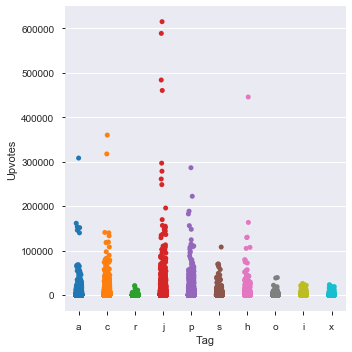

In [14]:
## Upvote - how dependent on the tag
%matplotlib inline
sns.catplot(x="Tag", y="Upvotes", data=data);

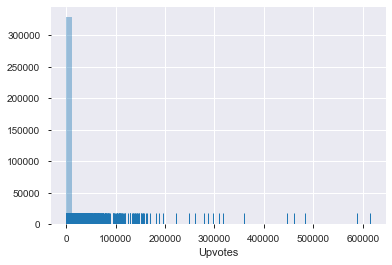

In [19]:
sns.distplot(data.Upvotes, bins=50, kde=False, rug=True);


### Data Manipulation

- shuffle the data.
- remove id and username feature for the first cut.
- convert categorical feature tag into.
- normalize the data.

- can bucketize few features - Upvotes. 

### Predict Upvote - Regression Phase 1 

In [21]:
data = shuffle(data)

In [44]:
print('Coloumn Names ', data.columns)
features = ['Reputation', 'Answers', 'Views']
label = ['Upvotes']

Coloumn Names  Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')


In [47]:
def preprocess_data(data_set, features, labels, scaler= None, binarizer= None , is_test_data = False):
    
    if not is_test_data:
        binarizer = LabelBinarizer()
        scaler = StandardScaler()
        binarizer.fit(data_set.Tag)
    
    X = np.concatenate((data_set[features].values, binarizer.transform(data_set.Tag)), axis = 1)
    y = data_set[labels].values
    if not is_test_data:
        scaler.fit(X)
    X = scaler.transform(X)    
    return X, y, scaler, binarizer

In [48]:
X, y, scaler, binarizer = preprocess_data(data_set=data, features=features, labels= label)

In [49]:
print('Shape of X', X.shape)
print('Shape of y', y.shape)

Shape of X (330045, 13)
Shape of y (330045, 1)


In [50]:
 X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [52]:
print('Shape of X train', X_train.shape)
print('Shape of y train', y_train.shape)

print('Shape of X val', X_val.shape)
print('Shape of y val', y_val.shape)

Shape of X train (264036, 13)
Shape of y train (264036, 1)
Shape of X val (66009, 13)
Shape of y val (66009, 1)


In [105]:
## Neural Network Using Tensorflow - Keras
### Sequential Model 
input_dimension = X_train.shape[1] # this represent number of features

### hyper parameters
epochs = 100
batch_size = 512

### model
model = Sequential()
model.add(Dense(64, input_shape=(input_dimension,), activation='tanh'))
model.add(Dense(27, activation='tanh'))
model.add(Dense(17, activation='tanh'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mae',
               metrics=['mae', 'mse'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_44 (Dense)             (None, 27)                1755      
_________________________________________________________________
dense_45 (Dense)             (None, 17)                476       
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 18        
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
_________________________________________________________________


In [106]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_data=(X_val, y_val))

Train on 264036 samples, validate on 66009 samples
Epoch 1/100
264036/264036 [==============================] - 5s 20us/sample - loss: 335.1139 - mae: 335.1140 - mse: 13327765.0000 - val_loss: 323.2456 - val_mae: 323.2455 - val_mse: 11764724.0000
Epoch 2/100
264036/264036 [==============================] - 3s 13us/sample - loss: 330.9679 - mae: 330.9680 - mse: 13322596.0000 - val_loss: 319.9394 - val_mae: 319.9394 - val_mse: 11760200.0000
Epoch 3/100
264036/264036 [==============================] - 3s 13us/sample - loss: 327.5519 - mae: 327.5519 - mse: 13317765.0000 - val_loss: 316.6261 - val_mae: 316.6260 - val_mse: 11755434.0000
Epoch 4/100
264036/264036 [==============================] - 3s 13us/sample - loss: 324.8425 - mae: 324.8427 - mse: 13313016.0000 - val_loss: 314.3415 - val_mae: 314.3416 - val_mse: 11750948.0000
Epoch 5/100
264036/264036 [==============================] - 3s 13us/sample - loss: 322.6443 - mae: 322.6439 - mse: 13308451.0000 - val_loss: 311.8274 - val_mae: 311

264036/264036 [==============================] - 3s 13us/sample - loss: 256.8021 - mae: 256.8020 - mse: 13021355.0000 - val_loss: 247.5863 - val_mae: 247.5863 - val_mse: 11470787.0000
Epoch 79/100
264036/264036 [==============================] - 3s 13us/sample - loss: 256.4490 - mae: 256.4489 - mse: 13018326.0000 - val_loss: 247.3604 - val_mae: 247.3604 - val_mse: 11468099.0000
Epoch 80/100
264036/264036 [==============================] - 3s 13us/sample - loss: 256.0598 - mae: 256.0599 - mse: 13015417.0000 - val_loss: 247.0104 - val_mae: 247.0104 - val_mse: 11465150.0000
Epoch 81/100
264036/264036 [==============================] - 3s 13us/sample - loss: 255.7229 - mae: 255.7229 - mse: 13012460.0000 - val_loss: 246.6506 - val_mae: 246.6507 - val_mse: 11462376.0000
Epoch 82/100
264036/264036 [==============================] - 3s 13us/sample - loss: 255.3361 - mae: 255.3361 - mse: 13009536.0000 - val_loss: 246.3291 - val_mae: 246.3290 - val_mse: 11459750.0000
Epoch 83/100
264036/264036 [

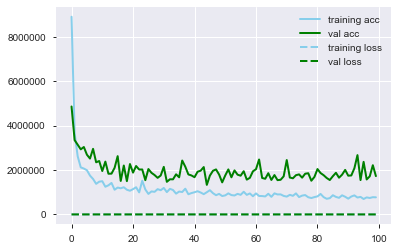

In [103]:
#plt.plot( history.history['mae'], color='skyblue', linewidth=2, label='training acc')
#plt.plot( history.history['val_mae'], color='green', linewidth=2, label='val acc')

plt.plot( history.history['mse'], color='skyblue', linewidth=2, label='training acc')
plt.plot( history.history['val_mse'], color='green', linewidth=2, label='val acc')

plt.plot( history.history['loss'], color='skyblue', linewidth=2, linestyle='dashed', label="training loss")
plt.plot( history.history['val_loss'], color='green', linewidth=2, linestyle='dashed', label="val loss")
plt.legend()


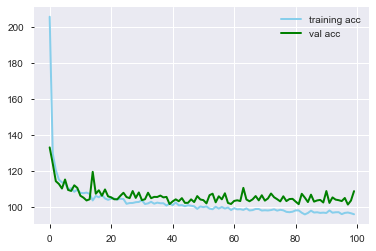

In [104]:
plt.plot( history.history['mae'], color='skyblue', linewidth=2, label='training acc')
plt.plot( history.history['val_mae'], color='green', linewidth=2, label='val acc')


plt.legend()

In [93]:
y_pred = model.predict(X_val)

In [99]:
print('MAE: ', mean_absolute_error(y_pred, y_val))
print('MSE: ', mean_squared_error(y_pred, y_val))


MAE:  149.24299609170063
MSE:  1836724.9780551065
